## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max,building_id
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4,1
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6,1
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5,1
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6,1
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2,1


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 35), (10847,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 35), (8696,), (1087, 24, 35), (1087,), (1064, 24, 35), (1064,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

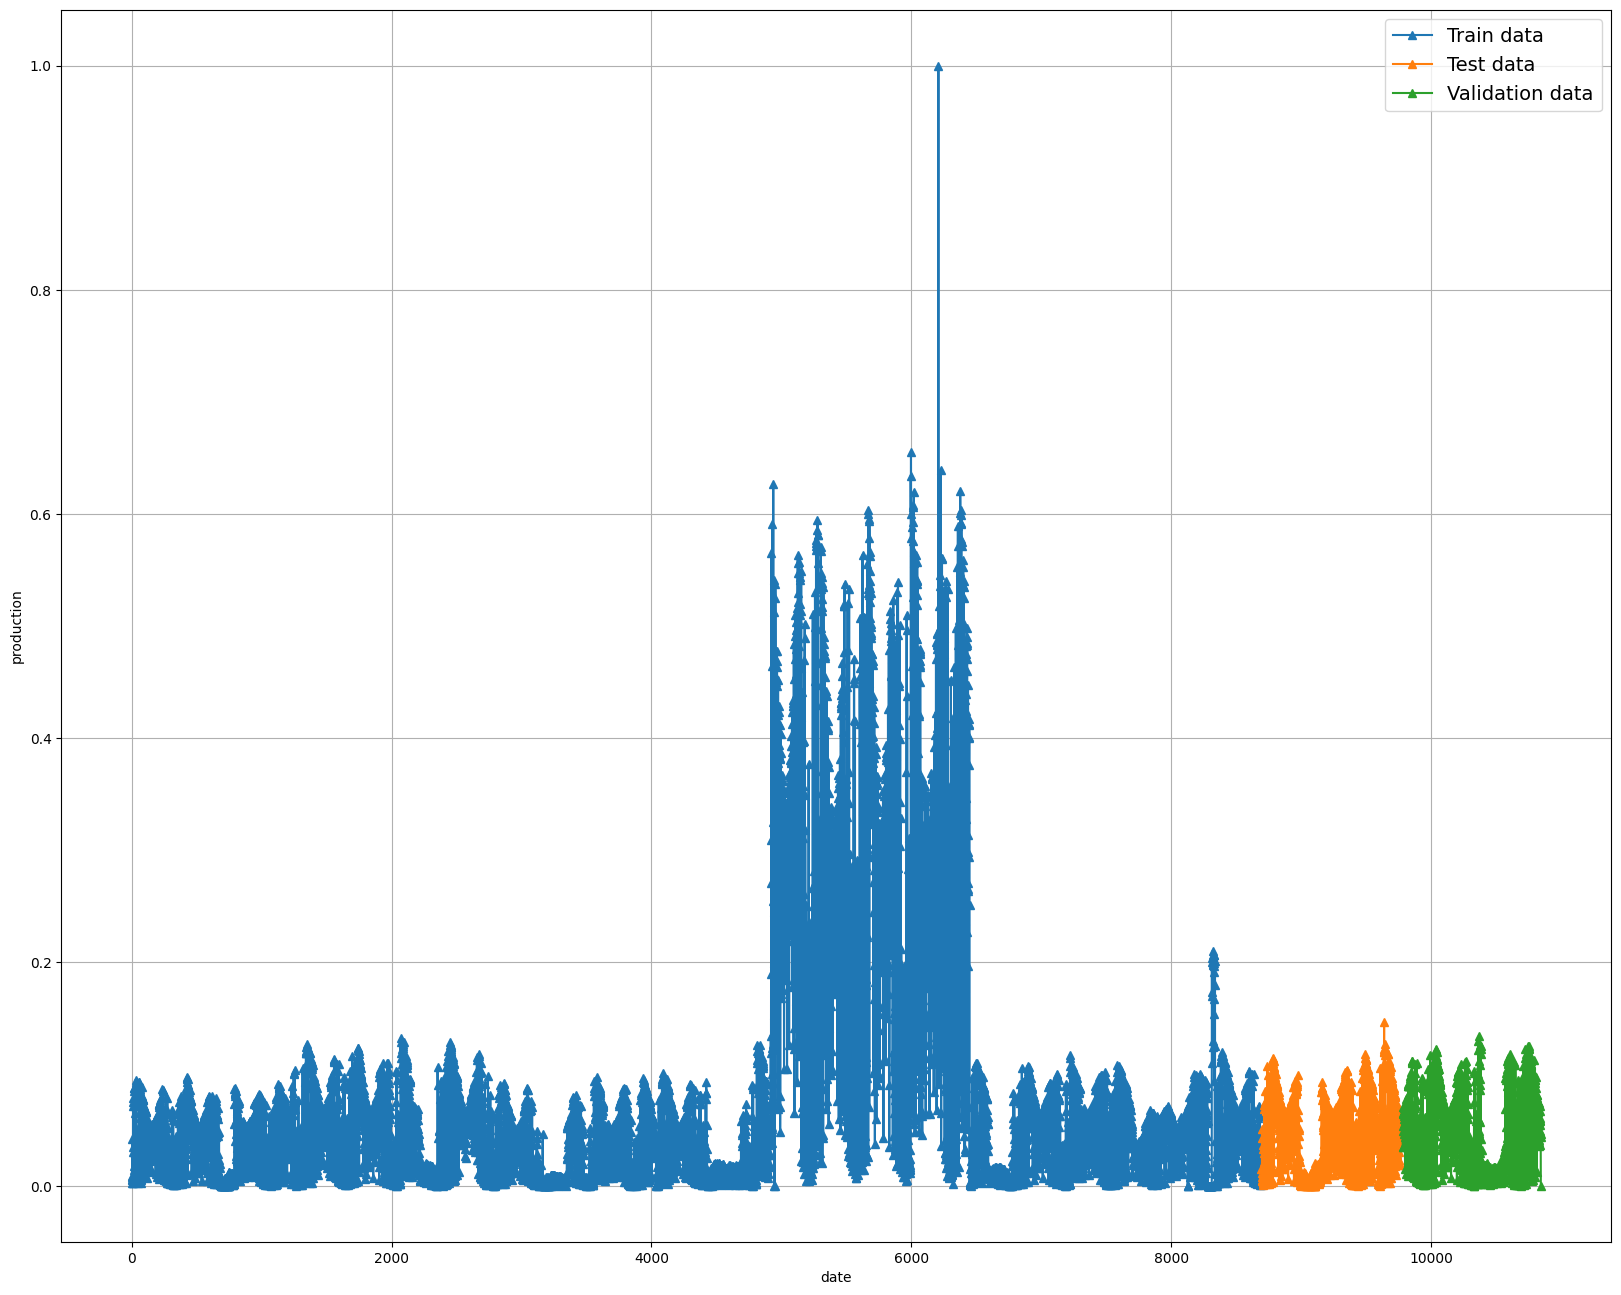

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 35) -> (8696, 24, 1, 35)


In [17]:
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense

# Hyperparamètres optimisés
filters = 32
kernel_size = 1
activation = 'tanh'
dense_units = 32
learning_rate = 0.005122099729062771

tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=False),
    Flatten(),
    Dense(units=dense_units, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

conv_lstm_model.summary()


Model: "model_conv_lstm.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 24, 1, 32)         8704      
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 32)             8320      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 18113 (70.75 KB)
Trainable params: 18113 (70.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 11:41:14] [setup] RAM Tracking...
[codecarbon INFO @ 11:41:14] [setup] CPU Tracking...
[codecarbon WARNING @ 11:41:14] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 11:41:16] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 11:41:16] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 11:41:16] [setup] GPU Tracking...
[codecarbon INFO @ 11:41:17] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:41:17] >>> Tracker's metadata:
[codecarbon INFO @ 11:41:17]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 11:41:17]   Python version: 3.11.3
[codecarbon INFO @ 11:41:17]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 11:41:17]   Available RAM : 31.711 GB
[codecarbon INFO @ 11:41:17]   CPU count: 20
[codecarbon INFO @ 11:41:17]   CPU

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300



[codecarbon INFO @ 11:41:28] Energy consumed for RAM : 0.000033 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:41:28] Energy consumed for all CPUs : 0.000118 kWh. Total CPU Power : 42.5 W


 3/17 [====>.........................] - ETA: 1s - loss: 0.1832 

[codecarbon INFO @ 11:41:29] Energy consumed for all GPUs : 0.000004 kWh. Total GPU Power : 1.557382268438878 W
[codecarbon INFO @ 11:41:29] 0.000156 kWh of electricity used since the beginning.


17/17 [==============================] - 15s 219ms/step - loss: 0.0776 - val_loss: 0.0288
Epoch 2/300
17/17 [==============================] - 2s 130ms/step - loss: 0.0423 - val_loss: 0.0277
Epoch 3/300
17/17 [==============================] - 2s 118ms/step - loss: 0.0405 - val_loss: 0.0277
Epoch 4/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0397

[codecarbon INFO @ 11:41:38] Energy consumed for RAM : 0.000061 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:41:38] Energy consumed for all CPUs : 0.000220 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 107ms/step - loss: 0.0398 - val_loss: 0.0270
Epoch 5/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0391

[codecarbon INFO @ 11:41:39] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 4.028871502075183 W
[codecarbon INFO @ 11:41:39] 0.000296 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 102ms/step - loss: 0.0392 - val_loss: 0.0265
Epoch 6/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0384 - val_loss: 0.0267
Epoch 7/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0388 - val_loss: 0.0276
Epoch 8/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0380 - val_loss: 0.0260
Epoch 9/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0367 - val_loss: 0.0254
Epoch 10/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0378

[codecarbon INFO @ 11:41:48] Energy consumed for RAM : 0.000090 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:41:48] Energy consumed for all CPUs : 0.000322 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 93ms/step - loss: 0.0368 - val_loss: 0.0258
Epoch 11/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0354

[codecarbon INFO @ 11:41:49] Energy consumed for all GPUs : 0.000024 kWh. Total GPU Power : 4.055093078837507 W
[codecarbon INFO @ 11:41:49] 0.000435 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 102ms/step - loss: 0.0367 - val_loss: 0.0251
Epoch 12/300
17/17 [==============================] - 2s 97ms/step - loss: 0.0362 - val_loss: 0.0264
Epoch 13/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0353 - val_loss: 0.0242
Epoch 14/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0353 - val_loss: 0.0269
Epoch 15/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0353 - val_loss: 0.0245
Epoch 16/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0321

[codecarbon INFO @ 11:41:58] Energy consumed for RAM : 0.000118 kWh. RAM Power : 11.891499996185303 W


 2/17 [==>...........................] - ETA: 1s - loss: 0.0337

[codecarbon INFO @ 11:41:58] Energy consumed for all CPUs : 0.000424 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0345

[codecarbon INFO @ 11:41:59] Energy consumed for all GPUs : 0.000033 kWh. Total GPU Power : 4.080887796400088 W
[codecarbon INFO @ 11:41:59] 0.000575 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0345 - val_loss: 0.0235
Epoch 17/300
17/17 [==============================] - 2s 95ms/step - loss: 0.0358 - val_loss: 0.0236
Epoch 18/300
17/17 [==============================] - 2s 87ms/step - loss: 0.0358 - val_loss: 0.0238
Epoch 19/300
17/17 [==============================] - 2s 90ms/step - loss: 0.0340 - val_loss: 0.0231
Epoch 20/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0335 - val_loss: 0.0224
Epoch 21/300
17/17 [==============================] - 2s 89ms/step - loss: 0.0333 - val_loss: 0.0217
Epoch 22/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0327

[codecarbon INFO @ 11:42:08] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:42:08] Energy consumed for all CPUs : 0.000525 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 92ms/step - loss: 0.0328 - val_loss: 0.0236
Epoch 23/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0327

[codecarbon INFO @ 11:42:09] Energy consumed for all GPUs : 0.000043 kWh. Total GPU Power : 4.139612535087307 W
[codecarbon INFO @ 11:42:09] 0.000715 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0333 - val_loss: 0.0216
Epoch 24/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0326 - val_loss: 0.0224
Epoch 25/300
17/17 [==============================] - 2s 90ms/step - loss: 0.0318 - val_loss: 0.0213
Epoch 26/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0326 - val_loss: 0.0206
Epoch 27/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0330 - val_loss: 0.0211
Epoch 28/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0329

[codecarbon INFO @ 11:42:18] Energy consumed for RAM : 0.000175 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:42:18] Energy consumed for all CPUs : 0.000627 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 106ms/step - loss: 0.0327 - val_loss: 0.0221
Epoch 29/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0321

[codecarbon INFO @ 11:42:19] Energy consumed for all GPUs : 0.000054 kWh. Total GPU Power : 4.25679620403708 W
[codecarbon INFO @ 11:42:19] 0.000855 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 99ms/step - loss: 0.0318 - val_loss: 0.0198
Epoch 30/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0321 - val_loss: 0.0212
Epoch 31/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0316 - val_loss: 0.0226
Epoch 32/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0328 - val_loss: 0.0230
Epoch 33/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0323 - val_loss: 0.0214
Epoch 34/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0311

[codecarbon INFO @ 11:42:28] Energy consumed for RAM : 0.000203 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:42:28] Energy consumed for all CPUs : 0.000729 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 102ms/step - loss: 0.0320 - val_loss: 0.0198


[codecarbon INFO @ 11:42:29] Energy consumed for all GPUs : 0.000064 kWh. Total GPU Power : 4.416198434447736 W


Epoch 35/300


[codecarbon INFO @ 11:42:29] 0.000996 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 107ms/step - loss: 0.0313 - val_loss: 0.0191
Epoch 36/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0314 - val_loss: 0.0194
Epoch 37/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0309 - val_loss: 0.0197
Epoch 38/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0310 - val_loss: 0.0199
Epoch 39/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0306

[codecarbon INFO @ 11:42:38] Energy consumed for RAM : 0.000232 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:42:38] Energy consumed for all CPUs : 0.000830 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 103ms/step - loss: 0.0304 - val_loss: 0.0186
Epoch 40/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0301

[codecarbon INFO @ 11:42:39] Energy consumed for all GPUs : 0.000074 kWh. Total GPU Power : 4.150914857761632 W
[codecarbon INFO @ 11:42:39] 0.001136 kWh of electricity used since the beginning.


17/17 [==============================] - ETA: 0s - loss: 0.0304

[codecarbon INFO @ 11:42:39] 0.000279 g.CO2eq/s mean an estimation of 8.795672447294887 kg.CO2eq/year


17/17 [==============================] - 1s 86ms/step - loss: 0.0304 - val_loss: 0.0195
Epoch 41/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0305 - val_loss: 0.0196
Epoch 42/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0317 - val_loss: 0.0203
Epoch 43/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0317 - val_loss: 0.0196
Epoch 44/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0318 - val_loss: 0.0219
Epoch 45/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0310

[codecarbon INFO @ 11:42:48] Energy consumed for RAM : 0.000260 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:42:48] Energy consumed for all CPUs : 0.000932 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 102ms/step - loss: 0.0309 - val_loss: 0.0194
Epoch 46/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0301

[codecarbon INFO @ 11:42:49] Energy consumed for all GPUs : 0.000084 kWh. Total GPU Power : 4.1894983670607795 W
[codecarbon INFO @ 11:42:49] 0.001277 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 92ms/step - loss: 0.0299 - val_loss: 0.0188
Epoch 47/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0310 - val_loss: 0.0190
Epoch 48/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0302 - val_loss: 0.0202
Epoch 49/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0306 - val_loss: 0.0198
Epoch 50/300
17/17 [==============================] - 2s 92ms/step - loss: 0.0311 - val_loss: 0.0212
Epoch 51/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0303

[codecarbon INFO @ 11:42:58] Energy consumed for RAM : 0.000289 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:42:58] Energy consumed for all CPUs : 0.001034 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 1s 87ms/step - loss: 0.0303 - val_loss: 0.0205
Epoch 52/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0299

[codecarbon INFO @ 11:42:59] Energy consumed for all GPUs : 0.000095 kWh. Total GPU Power : 4.453580454935455 W
[codecarbon INFO @ 11:42:59] 0.001418 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 88ms/step - loss: 0.0299 - val_loss: 0.0183
Epoch 53/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0300 - val_loss: 0.0184
Epoch 54/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0296 - val_loss: 0.0192
Epoch 55/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0293 - val_loss: 0.0189
Epoch 56/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0300 - val_loss: 0.0201
Epoch 57/300
17/17 [==============================] - ETA: 0s - loss: 0.0291

[codecarbon INFO @ 11:43:08] Energy consumed for RAM : 0.000317 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:43:08] Energy consumed for all CPUs : 0.001136 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 91ms/step - loss: 0.0291 - val_loss: 0.0178
Epoch 58/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0288

[codecarbon INFO @ 11:43:09] Energy consumed for all GPUs : 0.000104 kWh. Total GPU Power : 3.962223523940351 W
[codecarbon INFO @ 11:43:09] 0.001557 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 86ms/step - loss: 0.0289 - val_loss: 0.0183
Epoch 59/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0289 - val_loss: 0.0190
Epoch 60/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0289 - val_loss: 0.0179
Epoch 61/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0290 - val_loss: 0.0184
Epoch 62/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0285 - val_loss: 0.0177
Epoch 63/300
17/17 [==============================] - 1s 81ms/step - loss: 0.0287 - val_loss: 0.0194
Epoch 64/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0279

[codecarbon INFO @ 11:43:18] Energy consumed for RAM : 0.000345 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:43:18] Energy consumed for all CPUs : 0.001238 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 1s 81ms/step - loss: 0.0288 - val_loss: 0.0188
Epoch 65/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0301

[codecarbon INFO @ 11:43:19] Energy consumed for all GPUs : 0.000114 kWh. Total GPU Power : 4.064829147729599 W
[codecarbon INFO @ 11:43:19] 0.001697 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 84ms/step - loss: 0.0286 - val_loss: 0.0179
Epoch 66/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0283 - val_loss: 0.0177
Epoch 67/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0289 - val_loss: 0.0180
Epoch 68/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0289 - val_loss: 0.0183
Epoch 69/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0288 - val_loss: 0.0177
Epoch 70/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0278

[codecarbon INFO @ 11:43:28] Energy consumed for RAM : 0.000374 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:43:28] Energy consumed for all CPUs : 0.001339 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 95ms/step - loss: 0.0281 - val_loss: 0.0179
Epoch 71/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0283

[codecarbon INFO @ 11:43:29] Energy consumed for all GPUs : 0.000124 kWh. Total GPU Power : 4.133801551151296 W
[codecarbon INFO @ 11:43:29] 0.001837 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0277 - val_loss: 0.0174
Epoch 72/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0283 - val_loss: 0.0179
Epoch 73/300
17/17 [==============================] - 2s 92ms/step - loss: 0.0275 - val_loss: 0.0173
Epoch 74/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0273 - val_loss: 0.0177
Epoch 75/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0275 - val_loss: 0.0173
Epoch 76/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0271

[codecarbon INFO @ 11:43:38] Energy consumed for RAM : 0.000402 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:43:38] Energy consumed for all CPUs : 0.001441 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 100ms/step - loss: 0.0272 - val_loss: 0.0175
Epoch 77/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0277

[codecarbon INFO @ 11:43:39] Energy consumed for all GPUs : 0.000134 kWh. Total GPU Power : 4.140537005820414 W
[codecarbon INFO @ 11:43:39] 0.001977 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 89ms/step - loss: 0.0274 - val_loss: 0.0175
Epoch 78/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0274 - val_loss: 0.0176
Epoch 79/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0274 - val_loss: 0.0171
Epoch 80/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0274 - val_loss: 0.0180
Epoch 81/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0271 - val_loss: 0.0174
Epoch 82/300
10/17 [================>.............] - ETA: 0s - loss: 0.0268

[codecarbon INFO @ 11:43:48] Energy consumed for RAM : 0.000431 kWh. RAM Power : 11.891499996185303 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0268

[codecarbon INFO @ 11:43:48] Energy consumed for all CPUs : 0.001543 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 98ms/step - loss: 0.0269 - val_loss: 0.0182
Epoch 83/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0271

[codecarbon INFO @ 11:43:49] Energy consumed for all GPUs : 0.000144 kWh. Total GPU Power : 4.13678289451895 W
[codecarbon INFO @ 11:43:49] 0.002117 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0267 - val_loss: 0.0172
Epoch 84/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0270 - val_loss: 0.0171
Epoch 85/300
17/17 [==============================] - 2s 95ms/step - loss: 0.0266 - val_loss: 0.0168
Epoch 86/300
17/17 [==============================] - 2s 89ms/step - loss: 0.0270 - val_loss: 0.0184
Epoch 87/300
17/17 [==============================] - 1s 86ms/step - loss: 0.0264 - val_loss: 0.0167
Epoch 88/300
17/17 [==============================] - ETA: 0s - loss: 0.0266

[codecarbon INFO @ 11:43:58] Energy consumed for RAM : 0.000459 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:43:58] Energy consumed for all CPUs : 0.001645 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 102ms/step - loss: 0.0266 - val_loss: 0.0174
Epoch 89/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0275

[codecarbon INFO @ 11:43:59] Energy consumed for all GPUs : 0.000154 kWh. Total GPU Power : 4.155906296339863 W
[codecarbon INFO @ 11:43:59] 0.002257 kWh of electricity used since the beginning.


16/17 [===========================>..] - ETA: 0s - loss: 0.0272

[codecarbon INFO @ 11:43:59] 0.000280 g.CO2eq/s mean an estimation of 8.82711152528847 kg.CO2eq/year


17/17 [==============================] - 2s 89ms/step - loss: 0.0272 - val_loss: 0.0169
Epoch 90/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0261 - val_loss: 0.0166
Epoch 91/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0260 - val_loss: 0.0165
Epoch 92/300
17/17 [==============================] - 2s 112ms/step - loss: 0.0261 - val_loss: 0.0164
Epoch 93/300
17/17 [==============================] - 2s 97ms/step - loss: 0.0261 - val_loss: 0.0171
Epoch 94/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0267

[codecarbon INFO @ 11:44:08] Energy consumed for RAM : 0.000487 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:44:08] Energy consumed for all CPUs : 0.001746 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 102ms/step - loss: 0.0267 - val_loss: 0.0174
Epoch 95/300
10/17 [================>.............] - ETA: 0s - loss: 0.0262

[codecarbon INFO @ 11:44:09] Energy consumed for all GPUs : 0.000164 kWh. Total GPU Power : 4.170316201066303 W
[codecarbon INFO @ 11:44:09] 0.002397 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 97ms/step - loss: 0.0265 - val_loss: 0.0172
Epoch 96/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0270 - val_loss: 0.0171
Epoch 97/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0258 - val_loss: 0.0165
Epoch 98/300
17/17 [==============================] - 2s 114ms/step - loss: 0.0260 - val_loss: 0.0163
Epoch 99/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0252 - val_loss: 0.0166
Epoch 100/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0252

[codecarbon INFO @ 11:44:18] Energy consumed for RAM : 0.000516 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:44:18] Energy consumed for all CPUs : 0.001848 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 94ms/step - loss: 0.0253 - val_loss: 0.0166
Epoch 101/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0244

[codecarbon INFO @ 11:44:19] Energy consumed for all GPUs : 0.000174 kWh. Total GPU Power : 4.176638221565252 W
[codecarbon INFO @ 11:44:19] 0.002538 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 103ms/step - loss: 0.0250 - val_loss: 0.0159
Epoch 102/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0246 - val_loss: 0.0169
Epoch 103/300
17/17 [==============================] - 2s 113ms/step - loss: 0.0248 - val_loss: 0.0160
Epoch 104/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0253 - val_loss: 0.0177
Epoch 105/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0249

[codecarbon INFO @ 11:44:28] Energy consumed for RAM : 0.000544 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:44:28] Energy consumed for all CPUs : 0.001950 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 113ms/step - loss: 0.0249 - val_loss: 0.0156
Epoch 106/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0236

[codecarbon INFO @ 11:44:29] Energy consumed for all GPUs : 0.000184 kWh. Total GPU Power : 4.163011335129206 W
[codecarbon INFO @ 11:44:29] 0.002678 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 88ms/step - loss: 0.0250 - val_loss: 0.0175
Epoch 107/300
17/17 [==============================] - 1s 83ms/step - loss: 0.0247 - val_loss: 0.0158
Epoch 108/300
17/17 [==============================] - 1s 85ms/step - loss: 0.0243 - val_loss: 0.0160
Epoch 109/300
17/17 [==============================] - 1s 87ms/step - loss: 0.0244 - val_loss: 0.0156
Epoch 110/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0242 - val_loss: 0.0166
Epoch 111/300
17/17 [==============================] - 2s 87ms/step - loss: 0.0244 - val_loss: 0.0160
Epoch 112/300
 6/17 [=========>....................] - ETA: 0s - loss: 0.0228

[codecarbon INFO @ 11:44:38] Energy consumed for RAM : 0.000573 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:44:38] Energy consumed for all CPUs : 0.002052 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 1s 79ms/step - loss: 0.0241 - val_loss: 0.0154
Epoch 113/300
 6/17 [=========>....................] - ETA: 0s - loss: 0.0244

[codecarbon INFO @ 11:44:39] Energy consumed for all GPUs : 0.000194 kWh. Total GPU Power : 4.133501605856635 W
[codecarbon INFO @ 11:44:39] 0.002818 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 82ms/step - loss: 0.0244 - val_loss: 0.0165
Epoch 114/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0252 - val_loss: 0.0172
Epoch 115/300
17/17 [==============================] - 2s 92ms/step - loss: 0.0244 - val_loss: 0.0159
Epoch 116/300
17/17 [==============================] - 1s 83ms/step - loss: 0.0246 - val_loss: 0.0157
Epoch 117/300
17/17 [==============================] - 2s 97ms/step - loss: 0.0241 - val_loss: 0.0158
Epoch 118/300
17/17 [==============================] - 1s 88ms/step - loss: 0.0242 - val_loss: 0.0175
Epoch 119/300


[codecarbon INFO @ 11:44:48] Energy consumed for RAM : 0.000601 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:44:48] Energy consumed for all CPUs : 0.002153 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0242

[codecarbon INFO @ 11:44:49] Energy consumed for all GPUs : 0.000203 kWh. Total GPU Power : 4.140398350981222 W
[codecarbon INFO @ 11:44:49] 0.002958 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0242 - val_loss: 0.0164
Epoch 120/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0242 - val_loss: 0.0172
Epoch 121/300
17/17 [==============================] - 2s 94ms/step - loss: 0.0238 - val_loss: 0.0157
Epoch 122/300
17/17 [==============================] - 1s 89ms/step - loss: 0.0230 - val_loss: 0.0155
Epoch 123/300
17/17 [==============================] - 1s 89ms/step - loss: 0.0235 - val_loss: 0.0157
Epoch 124/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0234 - val_loss: 0.0151
Epoch 125/300
 6/17 [=========>....................] - ETA: 0s - loss: 0.0230

[codecarbon INFO @ 11:44:58] Energy consumed for RAM : 0.000629 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:44:58] Energy consumed for all CPUs : 0.002255 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 88ms/step - loss: 0.0227 - val_loss: 0.0151
Epoch 126/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0222

[codecarbon INFO @ 11:44:59] Energy consumed for all GPUs : 0.000214 kWh. Total GPU Power : 4.391295763103983 W
[codecarbon INFO @ 11:44:59] 0.003098 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 101ms/step - loss: 0.0230 - val_loss: 0.0160
Epoch 127/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0225 - val_loss: 0.0147
Epoch 128/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0228 - val_loss: 0.0152
Epoch 129/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0221 - val_loss: 0.0149
Epoch 130/300
17/17 [==============================] - 2s 113ms/step - loss: 0.0219 - val_loss: 0.0146
Epoch 131/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0244

[codecarbon INFO @ 11:45:08] Energy consumed for RAM : 0.000658 kWh. RAM Power : 11.891499996185303 W


 2/17 [==>...........................] - ETA: 1s - loss: 0.0222

[codecarbon INFO @ 11:45:08] Energy consumed for all CPUs : 0.002357 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0221

[codecarbon INFO @ 11:45:09] Energy consumed for all GPUs : 0.000224 kWh. Total GPU Power : 4.144068820604482 W
[codecarbon INFO @ 11:45:09] 0.003239 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 97ms/step - loss: 0.0221 - val_loss: 0.0148
Epoch 132/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0232 - val_loss: 0.0163
Epoch 133/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0226 - val_loss: 0.0146
Epoch 134/300
17/17 [==============================] - 2s 115ms/step - loss: 0.0214 - val_loss: 0.0140
Epoch 135/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0218 - val_loss: 0.0145
Epoch 136/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0211

[codecarbon INFO @ 11:45:18] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.891499996185303 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0211

[codecarbon INFO @ 11:45:18] Energy consumed for all CPUs : 0.002459 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 103ms/step - loss: 0.0213 - val_loss: 0.0142
Epoch 137/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0206

[codecarbon INFO @ 11:45:19] Energy consumed for all GPUs : 0.000234 kWh. Total GPU Power : 4.184344399050965 W
[codecarbon INFO @ 11:45:19] 0.003379 kWh of electricity used since the beginning.


12/17 [====================>.........] - ETA: 0s - loss: 0.0213

[codecarbon INFO @ 11:45:20] 0.000280 g.CO2eq/s mean an estimation of 8.83195839980987 kg.CO2eq/year


17/17 [==============================] - 2s 93ms/step - loss: 0.0216 - val_loss: 0.0141
Epoch 138/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0214 - val_loss: 0.0147
Epoch 139/300
17/17 [==============================] - 2s 113ms/step - loss: 0.0212 - val_loss: 0.0138
Epoch 140/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0207 - val_loss: 0.0137
Epoch 141/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0211 - val_loss: 0.0149
Epoch 142/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0203

[codecarbon INFO @ 11:45:28] Energy consumed for RAM : 0.000715 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:45:28] Energy consumed for all CPUs : 0.002560 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 1s 89ms/step - loss: 0.0212 - val_loss: 0.0146
Epoch 143/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0215

[codecarbon INFO @ 11:45:29] Energy consumed for all GPUs : 0.000245 kWh. Total GPU Power : 4.584755157023837 W
[codecarbon INFO @ 11:45:29] 0.003520 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 101ms/step - loss: 0.0210 - val_loss: 0.0141
Epoch 144/300
17/17 [==============================] - 2s 90ms/step - loss: 0.0202 - val_loss: 0.0148
Epoch 145/300
17/17 [==============================] - 1s 86ms/step - loss: 0.0204 - val_loss: 0.0138
Epoch 146/300
17/17 [==============================] - 2s 88ms/step - loss: 0.0205 - val_loss: 0.0138
Epoch 147/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0203 - val_loss: 0.0142
Epoch 148/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0197

[codecarbon INFO @ 11:45:38] Energy consumed for RAM : 0.000743 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:45:38] Energy consumed for all CPUs : 0.002662 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 99ms/step - loss: 0.0204 - val_loss: 0.0132
Epoch 149/300
 7/17 [===========>..................] - ETA: 0s - loss: 0.0197

[codecarbon INFO @ 11:45:39] Energy consumed for all GPUs : 0.000255 kWh. Total GPU Power : 4.278108035722477 W
[codecarbon INFO @ 11:45:39] 0.003660 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0198 - val_loss: 0.0132
Epoch 150/300
17/17 [==============================] - 2s 95ms/step - loss: 0.0195 - val_loss: 0.0133
Epoch 151/300
17/17 [==============================] - 1s 89ms/step - loss: 0.0200 - val_loss: 0.0136
Epoch 152/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0197 - val_loss: 0.0131
Epoch 153/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0200 - val_loss: 0.0136
Epoch 154/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0191

[codecarbon INFO @ 11:45:48] Energy consumed for RAM : 0.000771 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:45:48] Energy consumed for all CPUs : 0.002764 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 100ms/step - loss: 0.0193 - val_loss: 0.0134
Epoch 155/300
10/17 [================>.............] - ETA: 0s - loss: 0.0199

[codecarbon INFO @ 11:45:49] Energy consumed for all GPUs : 0.000265 kWh. Total GPU Power : 4.276543408717197 W
[codecarbon INFO @ 11:45:49] 0.003800 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 91ms/step - loss: 0.0199 - val_loss: 0.0132
Epoch 156/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0205 - val_loss: 0.0138
Epoch 157/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0199 - val_loss: 0.0131
Epoch 158/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0196 - val_loss: 0.0134
Epoch 159/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0201 - val_loss: 0.0134
Epoch 160/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0193

[codecarbon INFO @ 11:45:58] Energy consumed for RAM : 0.000800 kWh. RAM Power : 11.891499996185303 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0193

[codecarbon INFO @ 11:45:58] Energy consumed for all CPUs : 0.002866 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 97ms/step - loss: 0.0192 - val_loss: 0.0133
Epoch 161/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0188

[codecarbon INFO @ 11:45:59] Energy consumed for all GPUs : 0.000276 kWh. Total GPU Power : 4.278777599172269 W
[codecarbon INFO @ 11:45:59] 0.003941 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0192 - val_loss: 0.0136
Epoch 162/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0188 - val_loss: 0.0124
Epoch 163/300
17/17 [==============================] - 2s 97ms/step - loss: 0.0187 - val_loss: 0.0127
Epoch 164/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0188 - val_loss: 0.0125
Epoch 165/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0183 - val_loss: 0.0122
Epoch 166/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0184

[codecarbon INFO @ 11:46:08] Energy consumed for RAM : 0.000828 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:46:08] Energy consumed for all CPUs : 0.002967 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 94ms/step - loss: 0.0188 - val_loss: 0.0126
Epoch 167/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0183

[codecarbon INFO @ 11:46:09] Energy consumed for all GPUs : 0.000286 kWh. Total GPU Power : 4.279054555374164 W
[codecarbon INFO @ 11:46:09] 0.004081 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 88ms/step - loss: 0.0184 - val_loss: 0.0125
Epoch 168/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0179 - val_loss: 0.0123
Epoch 169/300
17/17 [==============================] - 2s 92ms/step - loss: 0.0178 - val_loss: 0.0120
Epoch 170/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0179 - val_loss: 0.0133
Epoch 171/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0183 - val_loss: 0.0127
Epoch 172/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0174

[codecarbon INFO @ 11:46:18] Energy consumed for RAM : 0.000857 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:46:18] Energy consumed for all CPUs : 0.003069 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 101ms/step - loss: 0.0177 - val_loss: 0.0137
Epoch 173/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0180

[codecarbon INFO @ 11:46:19] Energy consumed for all GPUs : 0.000296 kWh. Total GPU Power : 4.352830739447535 W
[codecarbon INFO @ 11:46:19] 0.004222 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 88ms/step - loss: 0.0182 - val_loss: 0.0130
Epoch 174/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0175 - val_loss: 0.0124
Epoch 175/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0173 - val_loss: 0.0124
Epoch 176/300
17/17 [==============================] - 2s 97ms/step - loss: 0.0176 - val_loss: 0.0122
Epoch 177/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0171 - val_loss: 0.0118
Epoch 178/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0169

[codecarbon INFO @ 11:46:28] Energy consumed for RAM : 0.000885 kWh. RAM Power : 11.891499996185303 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0168

[codecarbon INFO @ 11:46:28] Energy consumed for all CPUs : 0.003171 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 100ms/step - loss: 0.0172 - val_loss: 0.0117
Epoch 179/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0172

[codecarbon INFO @ 11:46:29] Energy consumed for all GPUs : 0.000307 kWh. Total GPU Power : 4.293635921954526 W
[codecarbon INFO @ 11:46:29] 0.004362 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 91ms/step - loss: 0.0174 - val_loss: 0.0117
Epoch 180/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0174 - val_loss: 0.0123
Epoch 181/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0171 - val_loss: 0.0124
Epoch 182/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0164 - val_loss: 0.0112
Epoch 183/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0162 - val_loss: 0.0117
Epoch 184/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0165

[codecarbon INFO @ 11:46:38] Energy consumed for RAM : 0.000913 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:46:38] Energy consumed for all CPUs : 0.003272 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 97ms/step - loss: 0.0165 - val_loss: 0.0124
Epoch 185/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0176

[codecarbon INFO @ 11:46:39] Energy consumed for all GPUs : 0.000317 kWh. Total GPU Power : 4.20251073626563 W
[codecarbon INFO @ 11:46:39] 0.004502 kWh of electricity used since the beginning.


14/17 [=======================>......] - ETA: 0s - loss: 0.0176

[codecarbon INFO @ 11:46:40] 0.000281 g.CO2eq/s mean an estimation of 8.85092517843184 kg.CO2eq/year


17/17 [==============================] - 2s 90ms/step - loss: 0.0173 - val_loss: 0.0111
Epoch 186/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0168 - val_loss: 0.0117
Epoch 187/300
17/17 [==============================] - 2s 98ms/step - loss: 0.0169 - val_loss: 0.0130
Epoch 188/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0167 - val_loss: 0.0111
Epoch 189/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0160 - val_loss: 0.0114
Epoch 190/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0163

[codecarbon INFO @ 11:46:48] Energy consumed for RAM : 0.000942 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:46:48] Energy consumed for all CPUs : 0.003374 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 95ms/step - loss: 0.0165 - val_loss: 0.0114
Epoch 191/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0167

[codecarbon INFO @ 11:46:49] Energy consumed for all GPUs : 0.000327 kWh. Total GPU Power : 4.209499081009539 W
[codecarbon INFO @ 11:46:49] 0.004643 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 89ms/step - loss: 0.0162 - val_loss: 0.0120
Epoch 192/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0163 - val_loss: 0.0110
Epoch 193/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0156 - val_loss: 0.0110
Epoch 194/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0158 - val_loss: 0.0124
Epoch 195/300
17/17 [==============================] - 2s 89ms/step - loss: 0.0157 - val_loss: 0.0110
Epoch 196/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0153

[codecarbon INFO @ 11:46:58] Energy consumed for RAM : 0.000970 kWh. RAM Power : 11.891499996185303 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0154

[codecarbon INFO @ 11:46:58] Energy consumed for all CPUs : 0.003476 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 99ms/step - loss: 0.0158 - val_loss: 0.0117
Epoch 197/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0156

[codecarbon INFO @ 11:46:59] Energy consumed for all GPUs : 0.000337 kWh. Total GPU Power : 4.303123967259895 W
[codecarbon INFO @ 11:46:59] 0.004783 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 92ms/step - loss: 0.0156 - val_loss: 0.0109
Epoch 198/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0151 - val_loss: 0.0107
Epoch 199/300
17/17 [==============================] - 2s 96ms/step - loss: 0.0154 - val_loss: 0.0117
Epoch 200/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0157 - val_loss: 0.0107
Epoch 201/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0156 - val_loss: 0.0109
Epoch 202/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0147

[codecarbon INFO @ 11:47:08] Energy consumed for RAM : 0.000999 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:47:08] Energy consumed for all CPUs : 0.003578 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 97ms/step - loss: 0.0150 - val_loss: 0.0107
Epoch 203/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0151

[codecarbon INFO @ 11:47:09] Energy consumed for all GPUs : 0.000347 kWh. Total GPU Power : 4.210357274113294 W
[codecarbon INFO @ 11:47:09] 0.004923 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 81ms/step - loss: 0.0149 - val_loss: 0.0109
Epoch 204/300
17/17 [==============================] - 2s 92ms/step - loss: 0.0147 - val_loss: 0.0110
Epoch 205/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0156 - val_loss: 0.0123
Epoch 206/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0157 - val_loss: 0.0110
Epoch 207/300
17/17 [==============================] - 2s 117ms/step - loss: 0.0150 - val_loss: 0.0106
Epoch 208/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0147

[codecarbon INFO @ 11:47:18] Energy consumed for RAM : 0.001027 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:47:18] Energy consumed for all CPUs : 0.003679 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 107ms/step - loss: 0.0146 - val_loss: 0.0105
Epoch 209/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0131

[codecarbon INFO @ 11:47:19] Energy consumed for all GPUs : 0.000357 kWh. Total GPU Power : 4.295012489075294 W
[codecarbon INFO @ 11:47:19] 0.005064 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 105ms/step - loss: 0.0144 - val_loss: 0.0101
Epoch 210/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0140 - val_loss: 0.0101
Epoch 211/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0141 - val_loss: 0.0102
Epoch 212/300
17/17 [==============================] - 2s 114ms/step - loss: 0.0141 - val_loss: 0.0097
Epoch 213/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0143

[codecarbon INFO @ 11:47:28] Energy consumed for RAM : 0.001055 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:47:28] Energy consumed for all CPUs : 0.003781 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 110ms/step - loss: 0.0142 - val_loss: 0.0104
Epoch 214/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0145

[codecarbon INFO @ 11:47:29] Energy consumed for all GPUs : 0.000368 kWh. Total GPU Power : 4.632038441619575 W
[codecarbon INFO @ 11:47:29] 0.005205 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 89ms/step - loss: 0.0146 - val_loss: 0.0099
Epoch 215/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0138 - val_loss: 0.0105
Epoch 216/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0138 - val_loss: 0.0100
Epoch 217/300
17/17 [==============================] - 2s 115ms/step - loss: 0.0137 - val_loss: 0.0096
Epoch 218/300
17/17 [==============================] - 2s 116ms/step - loss: 0.0137 - val_loss: 0.0096
Epoch 219/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0133

[codecarbon INFO @ 11:47:38] Energy consumed for RAM : 0.001084 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:47:38] Energy consumed for all CPUs : 0.003883 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 99ms/step - loss: 0.0137 - val_loss: 0.0101
Epoch 220/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0130

[codecarbon INFO @ 11:47:39] Energy consumed for all GPUs : 0.000380 kWh. Total GPU Power : 4.804407401857155 W
[codecarbon INFO @ 11:47:39] 0.005347 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 92ms/step - loss: 0.0138 - val_loss: 0.0104
Epoch 221/300
17/17 [==============================] - 1s 87ms/step - loss: 0.0135 - val_loss: 0.0103
Epoch 222/300
17/17 [==============================] - 2s 93ms/step - loss: 0.0135 - val_loss: 0.0096
Epoch 223/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0135 - val_loss: 0.0104
Epoch 224/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 225/300
10/17 [================>.............] - ETA: 0s - loss: 0.0129

[codecarbon INFO @ 11:47:48] Energy consumed for RAM : 0.001112 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:47:48] Energy consumed for all CPUs : 0.003985 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 1s 80ms/step - loss: 0.0132 - val_loss: 0.0104
Epoch 226/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0125

[codecarbon INFO @ 11:47:49] Energy consumed for all GPUs : 0.000390 kWh. Total GPU Power : 4.305259222881284 W
[codecarbon INFO @ 11:47:49] 0.005487 kWh of electricity used since the beginning.


17/17 [==============================] - 1s 86ms/step - loss: 0.0131 - val_loss: 0.0099
Epoch 227/300
17/17 [==============================] - 2s 90ms/step - loss: 0.0132 - val_loss: 0.0102
Epoch 228/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0129 - val_loss: 0.0097
Epoch 229/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0131 - val_loss: 0.0100
Epoch 230/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 231/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0124

[codecarbon INFO @ 11:47:58] Energy consumed for RAM : 0.001140 kWh. RAM Power : 11.891499996185303 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0124

[codecarbon INFO @ 11:47:58] Energy consumed for all CPUs : 0.004086 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 102ms/step - loss: 0.0127 - val_loss: 0.0099
Epoch 232/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0131

[codecarbon INFO @ 11:47:59] Energy consumed for all GPUs : 0.000401 kWh. Total GPU Power : 4.580762602446596 W
[codecarbon INFO @ 11:47:59] 0.005628 kWh of electricity used since the beginning.


11/17 [==================>...........] - ETA: 0s - loss: 0.0132

[codecarbon INFO @ 11:48:00] 0.000281 g.CO2eq/s mean an estimation of 8.865964636435965 kg.CO2eq/year


17/17 [==============================] - 2s 98ms/step - loss: 0.0131 - val_loss: 0.0091
Epoch 233/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0128 - val_loss: 0.0091
Epoch 234/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0125 - val_loss: 0.0099
Epoch 235/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0126 - val_loss: 0.0091
Epoch 236/300
17/17 [==============================] - 2s 113ms/step - loss: 0.0123 - val_loss: 0.0090
Epoch 237/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0127

[codecarbon INFO @ 11:48:08] Energy consumed for RAM : 0.001169 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:48:08] Energy consumed for all CPUs : 0.004188 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0123

[codecarbon INFO @ 11:48:09] Energy consumed for all GPUs : 0.000413 kWh. Total GPU Power : 4.784729856236947 W
[codecarbon INFO @ 11:48:09] 0.005770 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 98ms/step - loss: 0.0123 - val_loss: 0.0091
Epoch 238/300
17/17 [==============================] - 2s 103ms/step - loss: 0.0121 - val_loss: 0.0093
Epoch 239/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0126 - val_loss: 0.0091
Epoch 240/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0130 - val_loss: 0.0088
Epoch 241/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0119 - val_loss: 0.0094
Epoch 242/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0124

[codecarbon INFO @ 11:48:18] Energy consumed for RAM : 0.001197 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:48:18] Energy consumed for all CPUs : 0.004290 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 107ms/step - loss: 0.0124 - val_loss: 0.0090
Epoch 243/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0119

[codecarbon INFO @ 11:48:19] Energy consumed for all GPUs : 0.000423 kWh. Total GPU Power : 4.282705768992609 W
[codecarbon INFO @ 11:48:19] 0.005910 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0118 - val_loss: 0.0091
Epoch 244/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 245/300
17/17 [==============================] - 2s 101ms/step - loss: 0.0122 - val_loss: 0.0090
Epoch 246/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0115 - val_loss: 0.0085
Epoch 247/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0114 - val_loss: 0.0088
Epoch 248/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0112

[codecarbon INFO @ 11:48:28] Energy consumed for RAM : 0.001226 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:48:28] Energy consumed for all CPUs : 0.004392 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0113

[codecarbon INFO @ 11:48:28] Energy consumed for all GPUs : 0.000433 kWh. Total GPU Power : 4.302905261916202 W
[codecarbon INFO @ 11:48:28] 0.006050 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 93ms/step - loss: 0.0114 - val_loss: 0.0086
Epoch 249/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0119 - val_loss: 0.0085
Epoch 250/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0115 - val_loss: 0.0091
Epoch 251/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0120 - val_loss: 0.0087
Epoch 252/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0120 - val_loss: 0.0090
Epoch 253/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0117 - val_loss: 0.0092
Epoch 254/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0120

[codecarbon INFO @ 11:48:38] Energy consumed for RAM : 0.001258 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:48:38] Energy consumed for all CPUs : 0.004508 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 95ms/step - loss: 0.0119 - val_loss: 0.0089
Epoch 255/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0109

[codecarbon INFO @ 11:48:39] Energy consumed for all GPUs : 0.000443 kWh. Total GPU Power : 3.6947311595119454 W
[codecarbon INFO @ 11:48:39] 0.006209 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 96ms/step - loss: 0.0113 - val_loss: 0.0086
Epoch 256/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0111 - val_loss: 0.0085
Epoch 257/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0113 - val_loss: 0.0087
Epoch 258/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0116 - val_loss: 0.0092
Epoch 259/300
17/17 [==============================] - ETA: 0s - loss: 0.0110

[codecarbon INFO @ 11:48:48] Energy consumed for RAM : 0.001287 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:48:48] Energy consumed for all CPUs : 0.004610 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 111ms/step - loss: 0.0110 - val_loss: 0.0081
Epoch 260/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0110

[codecarbon INFO @ 11:48:50] Energy consumed for all GPUs : 0.000454 kWh. Total GPU Power : 4.2956420007172635 W
[codecarbon INFO @ 11:48:50] 0.006350 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 90ms/step - loss: 0.0111 - val_loss: 0.0083
Epoch 261/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 262/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 263/300
17/17 [==============================] - 2s 99ms/step - loss: 0.0115 - val_loss: 0.0088
Epoch 264/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0112 - val_loss: 0.0082
Epoch 265/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0105

[codecarbon INFO @ 11:48:58] Energy consumed for RAM : 0.001315 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:48:58] Energy consumed for all CPUs : 0.004711 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 104ms/step - loss: 0.0106 - val_loss: 0.0082
Epoch 266/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0111

[codecarbon INFO @ 11:49:00] Energy consumed for all GPUs : 0.000464 kWh. Total GPU Power : 4.29113725993904 W
[codecarbon INFO @ 11:49:00] 0.006490 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 96ms/step - loss: 0.0113 - val_loss: 0.0103
Epoch 267/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0108 - val_loss: 0.0082
Epoch 268/300
17/17 [==============================] - 2s 111ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 269/300
17/17 [==============================] - 2s 107ms/step - loss: 0.0106 - val_loss: 0.0086
Epoch 270/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0112 - val_loss: 0.0083
Epoch 271/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0113

[codecarbon INFO @ 11:49:08] Energy consumed for RAM : 0.001343 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:49:08] Energy consumed for all CPUs : 0.004813 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 97ms/step - loss: 0.0115 - val_loss: 0.0083
Epoch 272/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0104

[codecarbon INFO @ 11:49:10] Energy consumed for all GPUs : 0.000474 kWh. Total GPU Power : 4.2256734597532475 W
[codecarbon INFO @ 11:49:10] 0.006630 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 100ms/step - loss: 0.0113 - val_loss: 0.0089
Epoch 273/300
17/17 [==============================] - 2s 110ms/step - loss: 0.0108 - val_loss: 0.0078
Epoch 274/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0112 - val_loss: 0.0077
Epoch 275/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0102 - val_loss: 0.0078
Epoch 276/300
17/17 [==============================] - ETA: 0s - loss: 0.0111

[codecarbon INFO @ 11:49:18] Energy consumed for RAM : 0.001372 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:49:18] Energy consumed for all CPUs : 0.004914 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 105ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 277/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0116

[codecarbon INFO @ 11:49:20] Energy consumed for all GPUs : 0.000485 kWh. Total GPU Power : 4.425494077775948 W
[codecarbon INFO @ 11:49:20] 0.006771 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 94ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 278/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0105

[codecarbon INFO @ 11:49:20] 0.000285 g.CO2eq/s mean an estimation of 8.998564975481653 kg.CO2eq/year


17/17 [==============================] - 2s 104ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 279/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 280/300
17/17 [==============================] - 2s 100ms/step - loss: 0.0108 - val_loss: 0.0079
Epoch 281/300
17/17 [==============================] - 2s 102ms/step - loss: 0.0108 - val_loss: 0.0084
Epoch 282/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0102

[codecarbon INFO @ 11:49:28] Energy consumed for RAM : 0.001400 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:49:28] Energy consumed for all CPUs : 0.005016 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 108ms/step - loss: 0.0104 - val_loss: 0.0077
Epoch 283/300
 8/17 [=============>................] - ETA: 0s - loss: 0.0100

[codecarbon INFO @ 11:49:30] Energy consumed for all GPUs : 0.000495 kWh. Total GPU Power : 4.197055976645334 W
[codecarbon INFO @ 11:49:30] 0.006911 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0102 - val_loss: 0.0077
Epoch 284/300
17/17 [==============================] - 2s 109ms/step - loss: 0.0098 - val_loss: 0.0075
Epoch 285/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0097 - val_loss: 0.0077
Epoch 286/300
17/17 [==============================] - 2s 104ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 287/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0097 - val_loss: 0.0074
Epoch 288/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0101

[codecarbon INFO @ 11:49:38] Energy consumed for RAM : 0.001428 kWh. RAM Power : 11.891499996185303 W


 4/17 [======>.......................] - ETA: 1s - loss: 0.0100

[codecarbon INFO @ 11:49:38] Energy consumed for all CPUs : 0.005118 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 97ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 289/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0105

[codecarbon INFO @ 11:49:40] Energy consumed for all GPUs : 0.000505 kWh. Total GPU Power : 4.330677217395929 W
[codecarbon INFO @ 11:49:40] 0.007051 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 99ms/step - loss: 0.0098 - val_loss: 0.0075
Epoch 290/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0093 - val_loss: 0.0078
Epoch 291/300
17/17 [==============================] - 2s 108ms/step - loss: 0.0097 - val_loss: 0.0077
Epoch 292/300
17/17 [==============================] - 2s 112ms/step - loss: 0.0093 - val_loss: 0.0071
Epoch 293/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0095

[codecarbon INFO @ 11:49:48] Energy consumed for RAM : 0.001457 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:49:48] Energy consumed for all CPUs : 0.005220 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 104ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 294/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0094

[codecarbon INFO @ 11:49:50] Energy consumed for all GPUs : 0.000516 kWh. Total GPU Power : 4.569586883428873 W
[codecarbon INFO @ 11:49:50] 0.007192 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 92ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 295/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 296/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 297/300
17/17 [==============================] - 2s 106ms/step - loss: 0.0094 - val_loss: 0.0076
Epoch 298/300
17/17 [==============================] - 2s 105ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 299/300
 9/17 [==============>...............] - ETA: 0s - loss: 0.0094

[codecarbon INFO @ 11:49:58] Energy consumed for RAM : 0.001485 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:49:58] Energy consumed for all CPUs : 0.005321 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 102ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 300/300
 6/17 [=========>....................] - ETA: 0s - loss: 0.0085

[codecarbon INFO @ 11:50:00] Energy consumed for all GPUs : 0.000527 kWh. Total GPU Power : 4.785414179287177 W
[codecarbon INFO @ 11:50:00] 0.007334 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 95ms/step - loss: 0.0086 - val_loss: 0.0077


[codecarbon INFO @ 11:50:01] Energy consumed for RAM : 0.001489 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:50:01] Energy consumed for all CPUs : 0.005334 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:50:01] Energy consumed for all GPUs : 0.000538 kWh. Total GPU Power : 33.584872609510775 W
[codecarbon INFO @ 11:50:01] 0.007361 kWh of electricity used since the beginning.


#### Ploting the loss

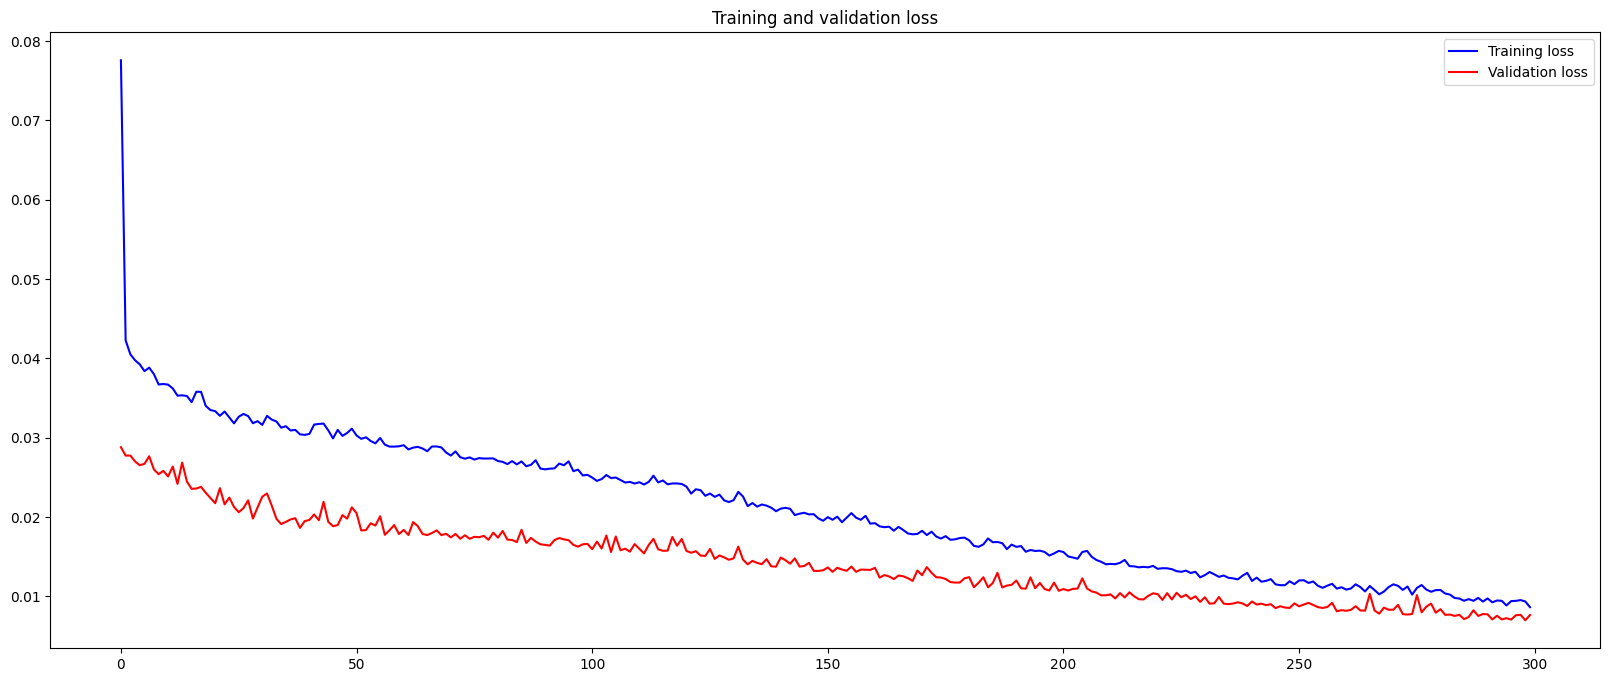

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 [==============================] - 2s 28ms/step


{'mae': 0.005894191, 'mse': 8.873861e-05, 'r2': 0.9207027554512024}

#### Plot predictions

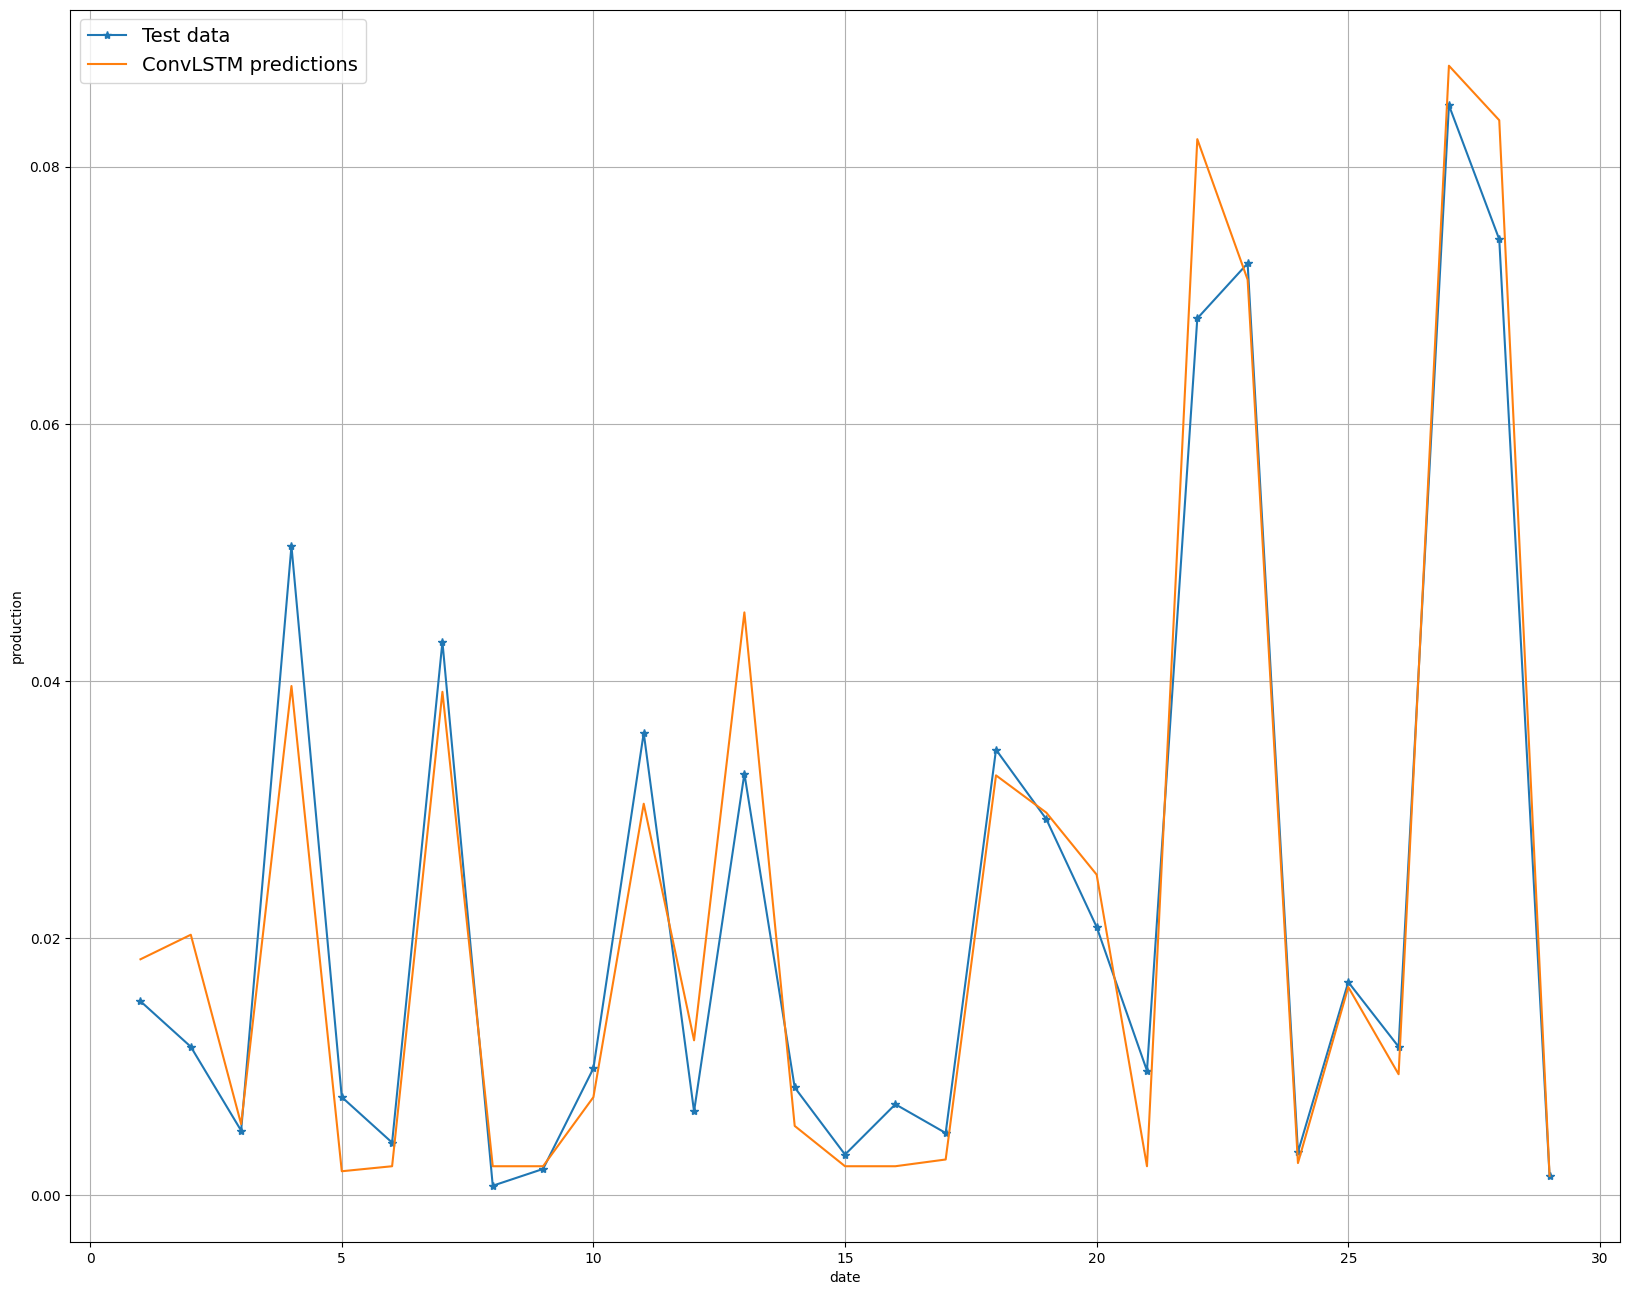

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)